In [2]:
import matplotlib.pyplot as plt

In [3]:
with open("names.txt", "r") as file:
    words = file.read()

words = words.splitlines()
print(f"Five first lines is: {words[:5]}")

Five first lines is: ['emma', 'olivia', 'ava', 'isabella', 'sophia']


In character language models some name (ie. Maya) is interpreted as:

- M is likely to come first ($P("M"|"")$ is higher than other letters)
- a is likely to come second if M is first ($P("a"|"M")$ is higher...)
- y is likely to come third if M is first and a is second ($P("y"|"Ma")$ is higher...)
- a is likely to come fourth if M is first, a is second and y is third ($P("a"|"May")$ is higher...)

## Bigram model

Bigrams are the simplest form of character language models. They are only concerned with consecutive pairs of letters. Each pair is called a bigram.

In [4]:
for word in words[:1]:
    for ch1, ch2 in zip(word, word[1:]):
        print(ch1, ch2)

e m
m m
m a


In order to understand where the start and end of a word is we need to add some special characters that will signalize that.

In [5]:
for word in words[:1]:
    w = ["<S>"] + list(word) + ["<E>"]
    for ch1, ch2 in zip(w, w[1:]):
        print(ch1, ch2)

<S> e
e m
m m
m a
a <E>


The simplest method to build a statistical method using bigrams is just to count them. The ```.get(key, value)``` is a dictionary metod to return a value of a given key or set a given optional value if the key is not found.

In [6]:
b = {}
for word in words:
    w = ["<S>"] + list(word) + ["<E>"]
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

b = dict(sorted(b.items(), key=lambda x: x[1], reverse=True)) # sorting the bigrams by count

Top50 bigrams

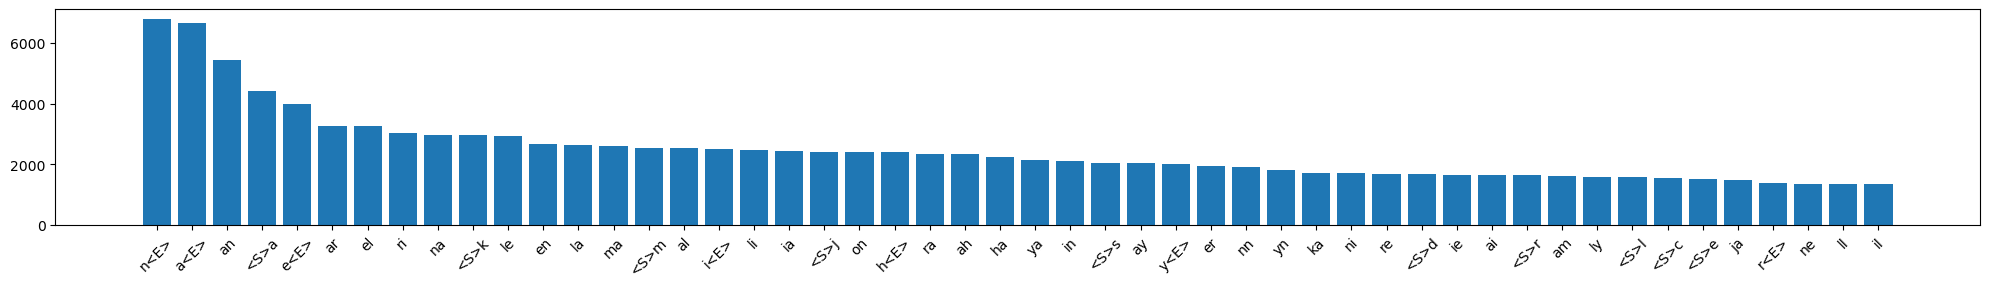

In [7]:
n = 50

plt.figure(figsize=(20, 3))
plt.bar([a+b for a, b in b.keys()][:n], list(b.values())[:n])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Using torch or numpy we can store this data more compactly. Imagine a cartesian product grid of all the characters in input data. As the indexes of a tensor are all integers we will also need a lookup table from a character to an index.

In [8]:
unique_chars = sorted(list(set("".join(words))))
stoi = {s:enum for enum, s in enumerate(unique_chars)}
stoi["<S>"] = 26
stoi["<E>"] = 27
stoi.items()

dict_items([('a', 0), ('b', 1), ('c', 2), ('d', 3), ('e', 4), ('f', 5), ('g', 6), ('h', 7), ('i', 8), ('j', 9), ('k', 10), ('l', 11), ('m', 12), ('n', 13), ('o', 14), ('p', 15), ('q', 16), ('r', 17), ('s', 18), ('t', 19), ('u', 20), ('v', 21), ('w', 22), ('x', 23), ('y', 24), ('z', 25), ('<S>', 26), ('<E>', 27)])

In [9]:
import numpy as np
import torch
import seaborn as sns

In [10]:
N = torch.zeros((28, 28), dtype=torch.int32)
for word in words:
    w = ["<S>"] + list(word) + ["<E>"]
    for ch1, ch2 in zip(w, w[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        N[ix1, ix2] += 1

Too bad these annots are not working. 

In [11]:
from itertools import product
annots = list(product(list(stoi.keys()),list(stoi.keys())))
annots = ["".join(annot) for annot in annots]
annots = list(zip(annots, [str(n.item()) for n in N.flatten()]))
annots = ["\n".join(annot) for annot in annots]
annots = np.array(annots).reshape(28, 28)

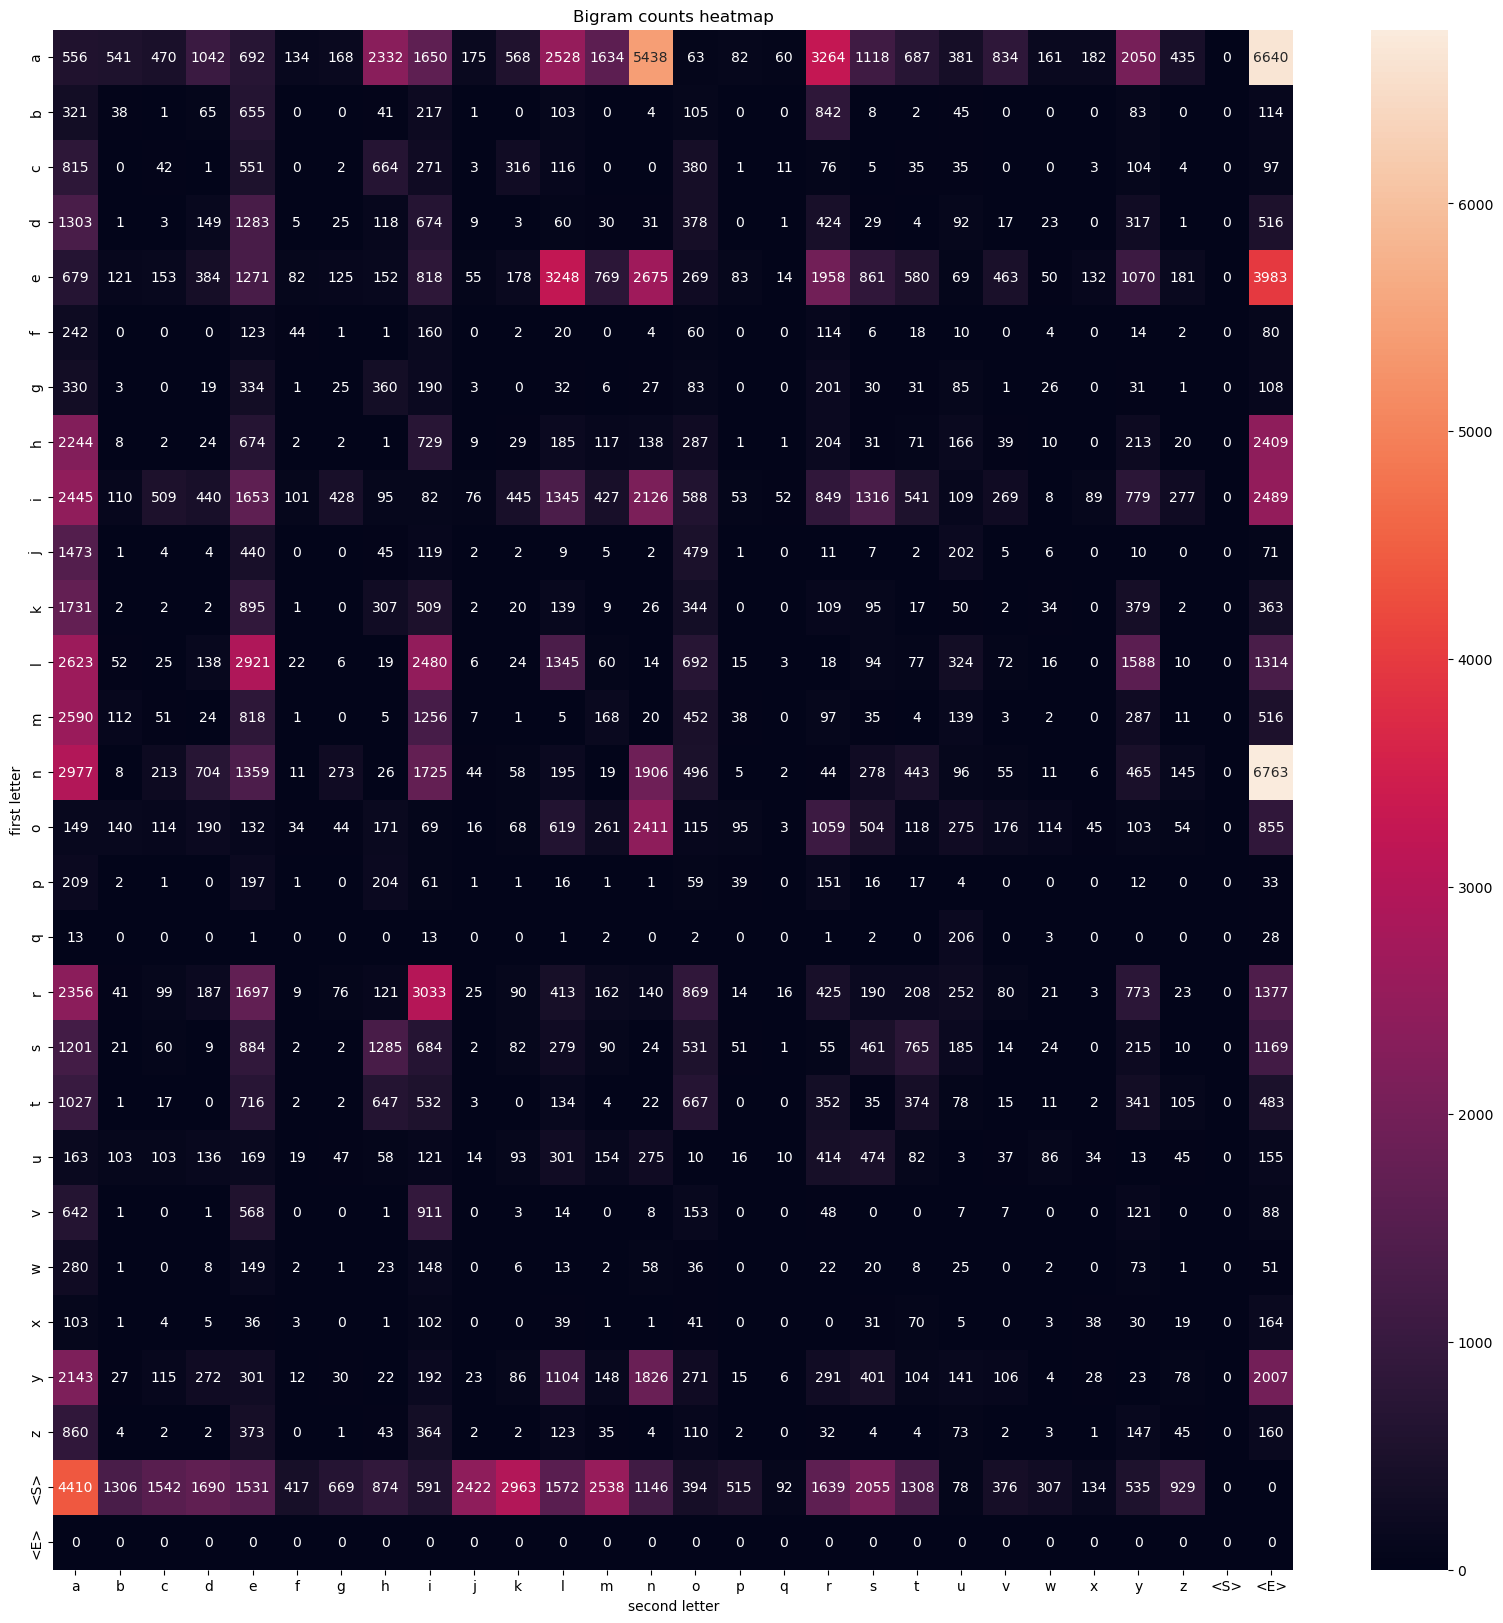

In [12]:
plt.figure(figsize=(20, 20))
sns.heatmap(N, xticklabels=list(stoi.keys()), yticklabels=list(stoi.keys()), annot=True, fmt="g")
plt.title("Bigram counts heatmap")
plt.xlabel("second letter")
plt.ylabel("first letter")
plt.show()

Having \<S\> and \<E\> as distinct special characters is in accordance with good practices of NLP. But it is only a waste of memory and space here. Instead we can use "." as both the starting and ending point. We'll also make a reversed dictionary.

In [13]:
unique_chars = sorted(list(set("".join(words))))
stoi = {s:enum+1 for enum, s in enumerate(unique_chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
print(stoi.items())
print(itos.items())

dict_items([('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5), ('f', 6), ('g', 7), ('h', 8), ('i', 9), ('j', 10), ('k', 11), ('l', 12), ('m', 13), ('n', 14), ('o', 15), ('p', 16), ('q', 17), ('r', 18), ('s', 19), ('t', 20), ('u', 21), ('v', 22), ('w', 23), ('x', 24), ('y', 25), ('z', 26), ('.', 0)])
dict_items([(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e'), (6, 'f'), (7, 'g'), (8, 'h'), (9, 'i'), (10, 'j'), (11, 'k'), (12, 'l'), (13, 'm'), (14, 'n'), (15, 'o'), (16, 'p'), (17, 'q'), (18, 'r'), (19, 's'), (20, 't'), (21, 'u'), (22, 'v'), (23, 'w'), (24, 'x'), (25, 'y'), (26, 'z'), (0, '.')])


In [14]:
N = torch.zeros((27, 27), dtype=torch.int32)
for word in words:
    w = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(w, w[1:]):
        ix1, ix2 = stoi[ch1], stoi[ch2]
        N[ix1, ix2] += 1

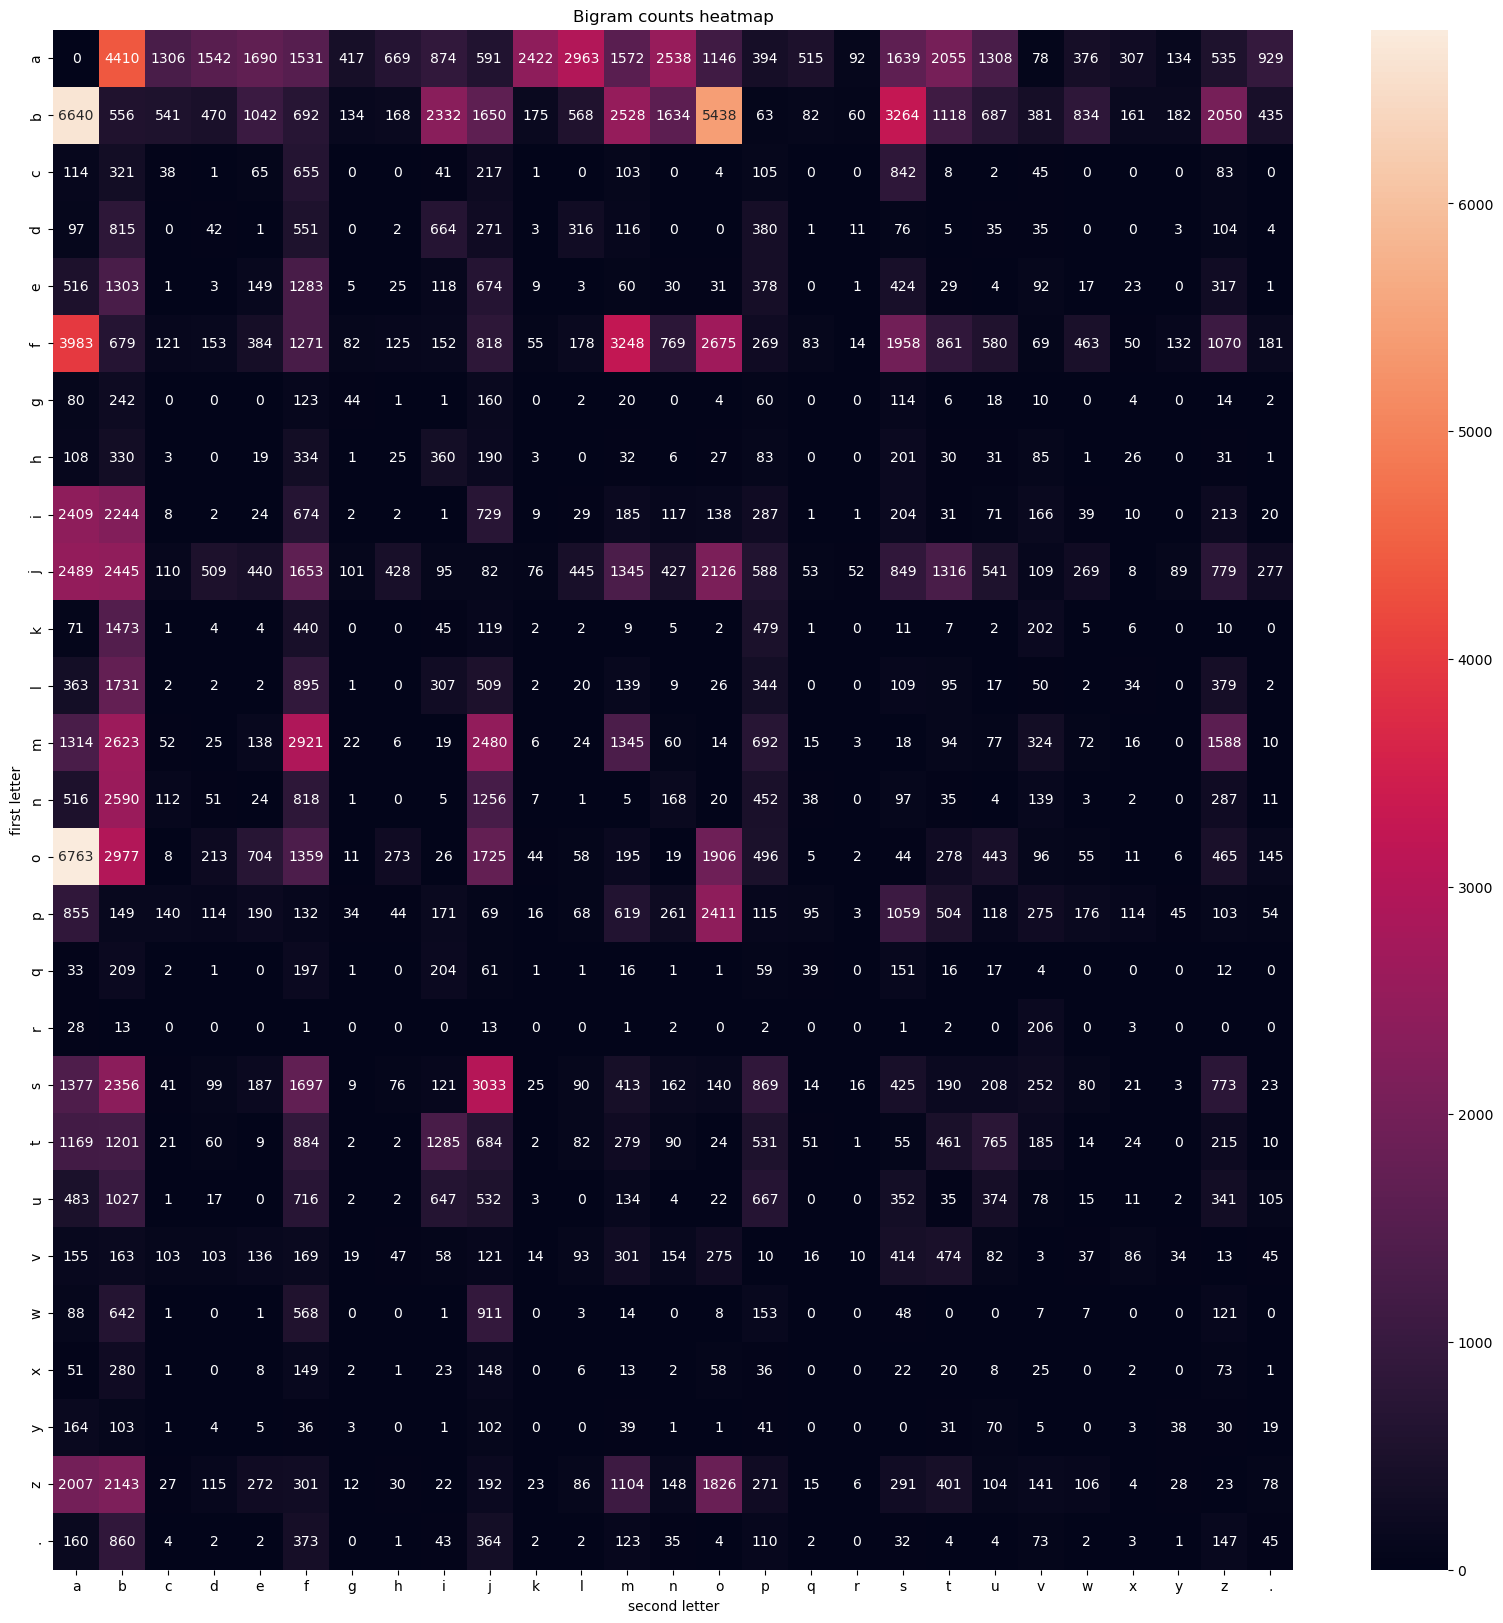

In [15]:
plt.figure(figsize=(20, 20))
sns.heatmap(N, xticklabels=list(stoi.keys()), yticklabels=list(stoi.keys()), annot=True, fmt="g")
plt.title("Bigram counts heatmap")
plt.xlabel("second letter")
plt.ylabel("first letter")
plt.show()

The use of ```torch.multinomial``` and ```torch.rand```

In [26]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
print(f"Probabilities are {p}")

samples = torch.multinomial(p, num_samples=10, replacement=True, generator=g)
print(f"Samples sampled from multinomial with given probabilities are {samples}")

Probabilities are tensor([0.6064, 0.3033, 0.0903])
Samples sampled from multinomial with given probabilities are tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0])


The simplest working of the bigram model can be implemented as below. It simply samples from a multinomial distribution until built out of counts from a file until it hits the end character - ".". Here it is used to generate 10 names.

In [48]:
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    ix = 0
    char = ""
    string = ""
    while char != ".":
        p = N[ix].float()
        p = p / p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        char = itos[ix]
        string += char
    print(string)

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
